In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'pandas'

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, RocCurveDisplay
from catboost import CatBoostClassifier, Pool

In [3]:
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_test

In [4]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


изучим уникальные значения в признаках 

In [7]:
cols = df.columns

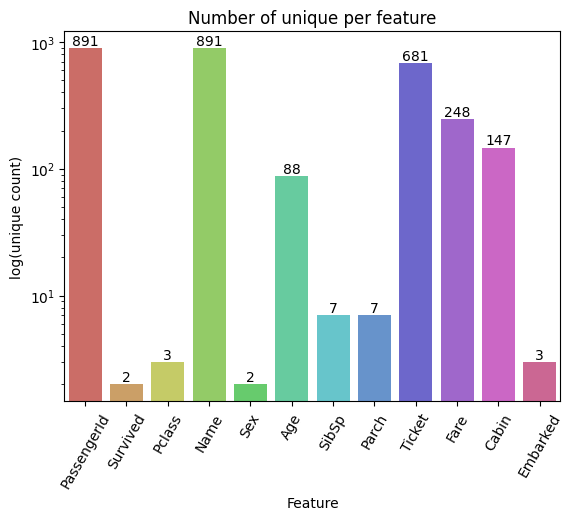

In [8]:

uniques = [df[col].nunique() for col in cols]

ax = sns.barplot(x=cols, y=uniques, palette='hls', log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique per feature')

for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.show()

изучение распределения всех признаков

<Axes: xlabel='Pclass', ylabel='Count'>

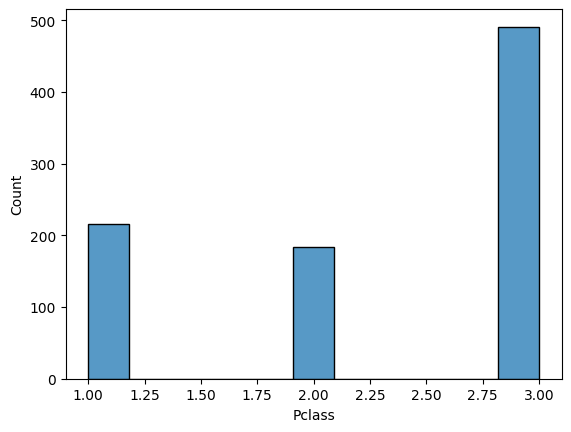

In [9]:
sns.histplot(df['Pclass'])

<Axes: xlabel='Sex', ylabel='Count'>

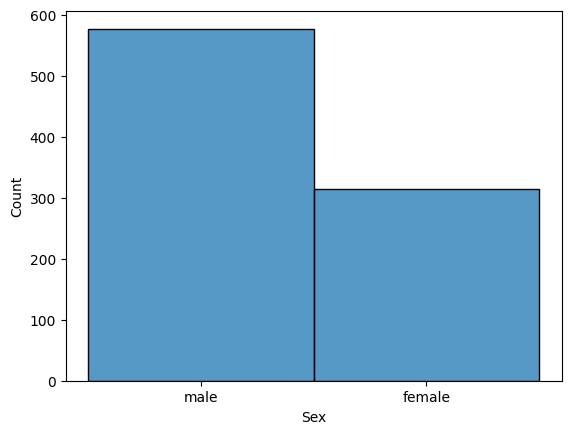

In [10]:
sns.histplot(df['Sex'])

<Axes: xlabel='Age', ylabel='Count'>

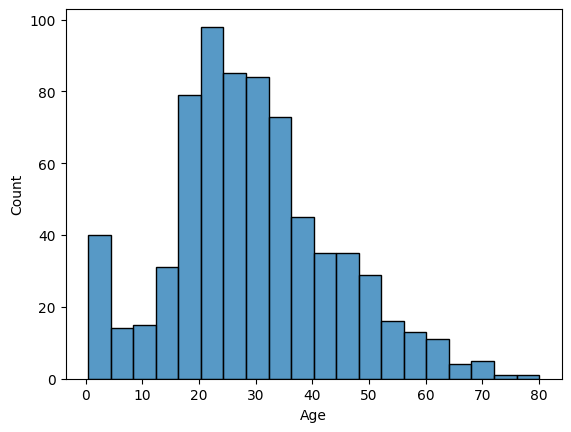

In [11]:
sns.histplot(df['Age'])

<Axes: xlabel='SibSp', ylabel='Count'>

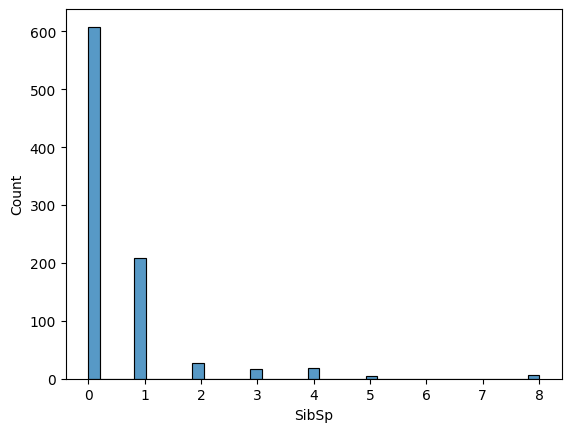

In [12]:
sns.histplot(df['SibSp'])

<Axes: xlabel='Parch', ylabel='Count'>

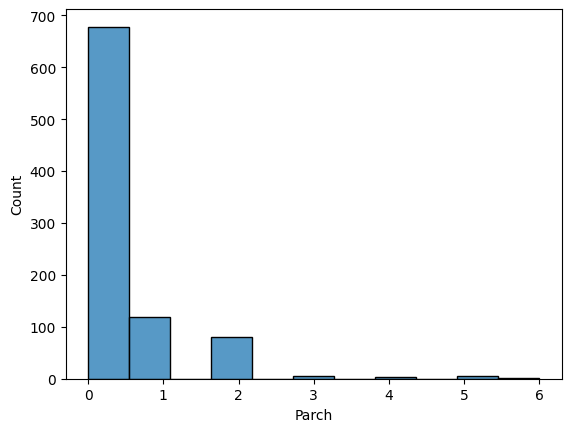

In [13]:
sns.histplot(df['Parch'])

<Axes: xlabel='Fare', ylabel='Count'>

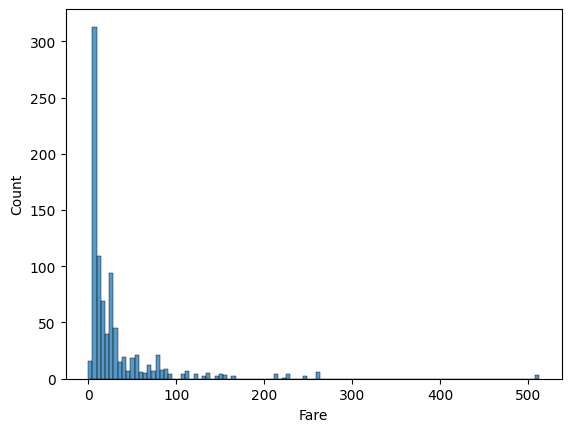

In [14]:
sns.histplot(df['Fare'])


<Axes: xlabel='Embarked', ylabel='Count'>

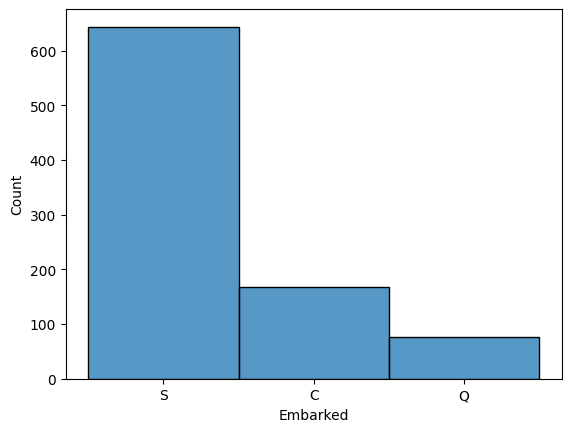

In [15]:
sns.histplot(df['Embarked'])

Изучение целевого признака

<Axes: xlabel='Survived', ylabel='Count'>

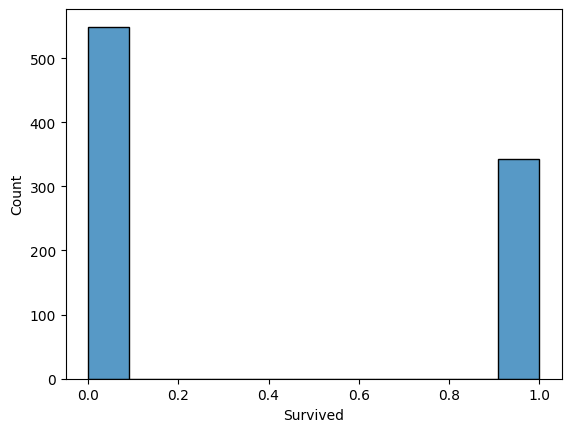

In [16]:
# проверим сотношние в целевой переменной
sns.histplot(df['Survived'])

In [17]:
cols = list(cols)
cols

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

<Axes: xlabel='Pclass', ylabel='Age'>

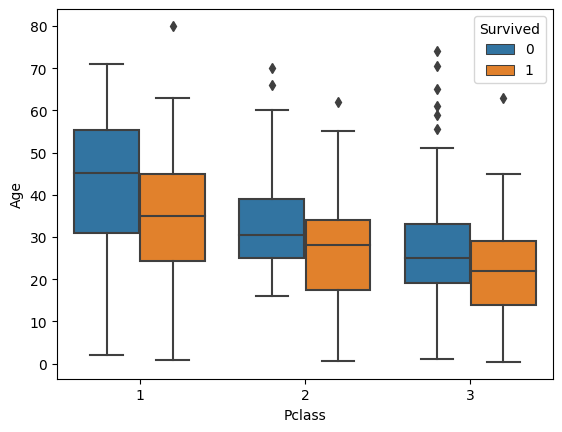

In [18]:
sns.boxplot(data=df, x="Pclass", y="Age", hue="Survived")

<Axes: xlabel='Survived', ylabel='Age'>

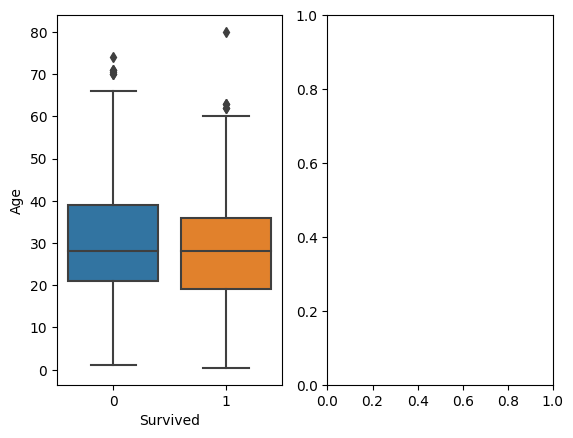

In [19]:
fig, axes = plt.subplots(1, 2)
sns.boxplot(data=df, x="Survived", y="Age", ax=axes[0])

Обработаем пустые значения

In [20]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [21]:
# Создадим ф-ю по обработке пустых значений
def fill_missed_data(data):
    #  пустые значения в столбце age заполним модой
    data["Age"] = data["Age"].fillna(data["Age"].mode()[0])
    
    
    # Выделим название палубы из номера комнаты
    data_deck = data[['PassengerId', 'Cabin']][~data['Cabin'].isna()]
    data_deck['Deck'] = data_deck['Cabin'].apply(lambda x: x[0])
    data_deck = data.merge(data_deck.drop('Cabin', axis=1), on='PassengerId', how='left')
    data.drop('Cabin', axis=1, inplace=True) # Удалим колонку CAbin
    # Заполним пустые значения значением UNKNOWN
    data['Deck'] = data_deck['Deck'].fillna('UNKNOWN')

In [22]:
fill_missed_data(df)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,UNKNOWN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,UNKNOWN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,UNKNOWN


In [23]:
fill_missed_data(df_test)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,UNKNOWN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,UNKNOWN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,UNKNOWN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,UNKNOWN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,UNKNOWN


Подготовим данные для обучения.

In [24]:
def model_preparing_data(data):
#     для обучения удалим колонки Name, PassengerId
    data.drop(['Name'], axis=1, inplace=True)
    # на 1 этапе дроопнем и колонку Ticket
    data.drop(('Ticket'), axis=1, inplace=True)
    

In [25]:
df_train = df
model_preparing_data(df_train)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,1,0,3,male,22.0,1,0,7.2500,S,UNKNOWN
1,2,1,1,female,38.0,1,0,71.2833,C,C
2,3,1,3,female,26.0,0,0,7.9250,S,UNKNOWN
3,4,1,1,female,35.0,1,0,53.1000,S,C
4,5,0,3,male,35.0,0,0,8.0500,S,UNKNOWN


In [26]:
model_preparing_data(df_test)
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,892,3,male,34.5,0,0,7.8292,Q,UNKNOWN
1,893,3,female,47.0,1,0,7.0000,S,UNKNOWN
2,894,2,male,62.0,0,0,9.6875,Q,UNKNOWN
3,895,3,male,27.0,0,0,8.6625,S,UNKNOWN
4,896,3,female,22.0,1,1,12.2875,S,UNKNOWN


In [27]:
numeric_columns = df_train.loc[:,df_train.dtypes!=object].columns
cat_columns = df_train.loc[:,df_train.dtypes==object].columns

In [28]:
one_hot_col = []
mean_target_col = []
for col in cat_columns:
    if df_train[col].nunique() <= 3:
        one_hot_col.append(col)
    else:
        mean_target_col.append(col)


one_hot_col, mean_target_col

(['Sex', 'Embarked'], ['Deck'])

In [29]:
train, valid = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
301,302,1,3,male,24.0,2,0,23.2500,Q,UNKNOWN
309,310,1,1,female,30.0,0,0,56.9292,C,E
516,517,1,2,female,34.0,0,0,10.5000,S,F
120,121,0,2,male,21.0,2,0,73.5000,S,UNKNOWN
570,571,1,2,male,62.0,0,0,10.5000,S,UNKNOWN


In [30]:
valid.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
862,863,1,1,female,48.0,0,0,25.9292,S,D
223,224,0,3,male,24.0,0,0,7.8958,S,UNKNOWN
84,85,1,2,female,17.0,0,0,10.5000,S,UNKNOWN
680,681,0,3,female,24.0,0,0,8.1375,Q,UNKNOWN
535,536,1,2,female,7.0,0,2,26.2500,S,UNKNOWN


In [31]:
# Создадим ф-ю предобработки данных
def premodified(data, name: str ='valid' ):
    #Обработаем колонки one_hot_encoding
    for col in one_hot_col:
        one_hot = pd.get_dummies(data[col], prefix=col, drop_first=True, dtype=int)
#         print(one_hot)
        data = pd.concat((data.drop(col, axis=1), one_hot), axis=1, copy=False)
#         print(pd.concat((data.drop(col, axis=1), one_hot), axis=1, copy=False))
#         print(data)

    #Обработаем колонки mean_target_encoding
    for col in mean_target_col:
        # чтобы не переобучиться используем данные только из трейновой колонки
        if name=='test':
            mean_target = df_train.groupby([col])['Survived'].mean() 
        else:
            mean_target = train.groupby([col])['Survived'].mean() 
        
        data[col] = data[col].replace(mean_target)
        
    return data

In [32]:
# применим mean_target encoding для тестовой и валидной данных
valid = premodified(valid)
train =  premodified(train)

In [61]:
df_train_f = premodified(df_train, name='test')
df_train_f.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Deck,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0.299854,1,0,1
1,2,1,1,38.0,1,0,71.2833,0.593220,0,0,0
2,3,1,3,26.0,0,0,7.9250,0.299854,0,0,1
3,4,1,1,35.0,1,0,53.1000,0.593220,0,0,1
4,5,0,3,35.0,0,0,8.0500,0.299854,1,0,1


In [33]:
df_test =  premodified(df_test, name='test')
df_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Deck,Sex_male,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0.299854,1,1,0
1,893,3,47.0,1,0,7.0000,0.299854,0,0,1
2,894,2,62.0,0,0,9.6875,0.299854,1,1,0
3,895,3,27.0,0,0,8.6625,0.299854,1,0,1
4,896,3,22.0,1,1,12.2875,0.299854,0,0,1


In [62]:
X = df_train_f.drop(['Survived',  'PassengerId'], axis=1)
y = df_train_f['Survived']

In [34]:
X_train = train.drop(['Survived',  'PassengerId'], axis=1)
y_train = train['Survived']

X_valid = valid.drop(['Survived',  'PassengerId'], axis=1)
y_valid = valid['Survived']

In [51]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Deck,Sex_male,Embarked_Q,Embarked_S
301,3,24.0,2,0,23.2500,0.287020,1,1,0
309,1,30.0,0,0,56.9292,0.833333,0,0,0
516,2,34.0,0,0,10.5000,0.666667,0,0,1
120,2,21.0,2,0,73.5000,0.287020,1,0,1
570,2,62.0,0,0,10.5000,0.287020,1,0,1


In [35]:
# Напишем полезные функции для обучения, и валидации, и изображения

In [36]:
#Создадим ф-ю обучения gridsearch
def train_gridsearch(model, param_grid, X, y, name):
    kfold = KFold(n_splits=3)
    
    pipeline = Pipeline([(name, model)])
    
    grid_search = GridSearchCV(model, 
                              param_grid=param_grid,
                              cv=kfold,
                              scoring='accuracy')
    grid_search.fit(X, y)
    
#     выведем лучшую метрику и лучшую модель
    print('The best model params: ', grid_search.best_params_)
    print('The best model score: ', grid_search.best_score_)
    
    return grid_search.best_estimator_

In [37]:
# функция вывода метрик
def model_metrics(model, name: str):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_valid)

    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_valid = accuracy_score(y_valid, y_val_pred)
    
#     y_pred_all = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)
    y_valid_pred_proba = model.predict_proba(X_valid)
    
    rocauc_train = roc_auc_score(y_train, y_train_pred_proba[:,1])
    rocauc_valid = roc_auc_score(y_valid, y_valid_pred_proba[:,1])
    
    print(f'{name} accuracy на трейновой выборке = {accuracy_train}')
    print(f'{name} accuracy на валидной выборке = {accuracy_valid}')
    
    print(f'{name} RocAUC на трейновой выборке = {rocauc_train}')
    print(f'{name} RocAUC на валидной выборке = {rocauc_valid}')


In [38]:
def print_roc_auc(model, name):
    '''Фукнция изображения rocauc на валидной X_valid
    '''
    y_pred_prob_val = model.predict_proba(X_valid)
    
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob_val[:, 1])
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label="ROC curve")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(name)
    plt.legend(loc='lower right')
#     RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
#     plt.show()

In [39]:
# Создадим ф-ю, которая обучает и валидирует лучшую модель на валидных данных
def train_valid(model, param_grid, X_train, y_train, name:'str'):
    
    best_model = train_gridsearch(model=model,
                                 param_grid=param_grid,
                                 X=X_train,
                                 y=y_train,
                                 name=name)
    
    model_metrics(best_model, name)
    
    print_roc_auc(best_model, name)
    
    return best_model

Обучим модель randomforestclassifier

The best model params:  {'n_estimators': 250}
The best model score:  0.8244867567280076
RFC accuracy на трейновой выборке = 0.9915730337078652
RFC accuracy на валидной выборке = 0.7597765363128491
RFC RocAUC на трейновой выборке = 0.9988965065831985
RFC RocAUC на валидной выборке = 0.8342594985784438


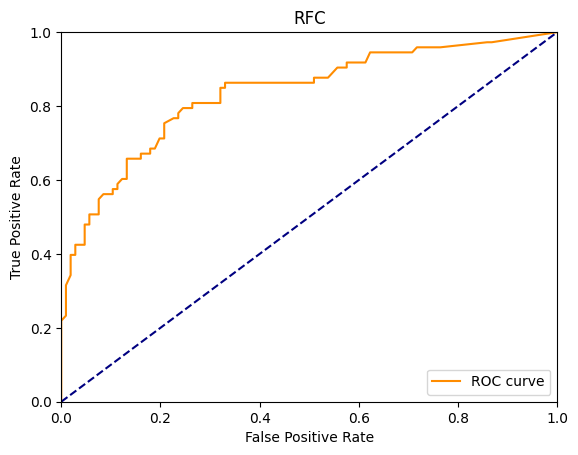

In [40]:
model_RFC = RandomForestClassifier()

name='RFC'

param_grid_RFC = {
    f'n_estimators': [100, 200, 250],
    
#     f'{name}__criterion': ['gini', 'entropy'],# 'log_loss'],
#     f'{name}__max_depth': [15, 20, 25, None],
#     f'{name}__min_samples_split': [2, 5, 10],
#     f'{name}__random_state': [200, 300, 400],
#     f'{name}__min_samples_leaf': [15, 20, 25],
#     f'{name}__class_weight': [None, 'balanced', 'balanced_subsample'],
#     f'name__max_features': ['sqrt', 'log2', None]
}

best_RFC = train_valid(model=model_RFC,
                     param_grid=param_grid_RFC,
                     X_train=X_train,
                     y_train=y_train,
                     name=name)



In [41]:
# Обучим модель catboost 
SEED = 100
cat_model = CatBoostClassifier(early_stopping_rounds=20,
                               custom_metric='Accuracy',
                              eval_metric='Accuracy',
                              random_seed=SEED,
                              verbose=False)

grid = {'random_seed': [0, 400],
        'iterations': [100, 500, 1000],
        'learning_rate': [0.03, 0.1, 0.2],
        'depth': [3, 6, 10],
        'l2_leaf_reg': [1, 5, 10]}

# cat_model.fit(X_train, y_train, verbose=False, eval_set=(X_valid, y_valid),  use_best_model=True)

# Применим встроенную ф-ю gridsearchcv
grid_search_result = cat_model.grid_search(param_grid=grid,
                                             X=X_train,
                                             y=y_train,
                                             verbose=False,
                                           
                                          )


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7762237762
bestIteration = 2

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8251748252
bestIteration = 56

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8111888112
bestIteration = 14

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7832167832
bestIteration = 2

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8111888112
bestIteration = 26

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8181818182
bestIteration = 12

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7832167832
bestIteration = 2

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8111888112
bestIteration = 27

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8321678322
bestIteration = 27

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7762237762
bestIteration = 2

Stopped by ove

In [42]:
print(f'Params: {grid_search_result["params"]}')
print(f'the best accuracy is : {cat_model.best_score_}')
model_metrics(cat_model, name='CatBoost_1')
# cat_model.get_all_params()



Params: {'depth': 3, 'random_seed': 400, 'l2_leaf_reg': 5, 'iterations': 100, 'learning_rate': 0.2}
the best accuracy is : {'learn': {'Accuracy': 0.8665730337078652, 'Logloss': 0.35547068967088785}}
CatBoost_1 accuracy на трейновой выборке = 0.8665730337078652
CatBoost_1 accuracy на валидной выборке = 0.7988826815642458
CatBoost_1 RocAUC на трейновой выборке = 0.9089764783874732
CatBoost_1 RocAUC на валидной выборке = 0.8338718014990953


In [43]:
cat_model_2 = CatBoostClassifier(early_stopping_rounds=20,
                               custom_metric='Accuracy',
                              eval_metric='Accuracy',
                              random_seed=SEED,
                                verbose=False)
# Применим встроенную ф-ю randomized_search
random_search_result = cat_model_2.randomized_search(param_distributions=grid,
                                             X=X_train,
                                             y=y_train,
                                             verbose=False
                                          )


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8041958042
bestIteration = 6

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7972027972
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8181818182
bestIteration = 7

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8041958042
bestIteration = 1

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8251748252
bestIteration = 44

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7902097902
bestIteration = 1

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8321678322
bestIteration = 5

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8181818182
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8181818182
bestIteration = 9

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8181818182
bestIteration = 5

Training on fold [0

In [44]:
# model_metrics(cat_model, 'CatBoost')
print(f'Random params: {random_search_result["params"]}')
print(f'the best accuracy is : {cat_model_2.best_score_}')
model_metrics(cat_model_2, name='CatBoost_2_random')
# cat_model.get_all_params()

Random params: {'depth': 10, 'random_seed': 400, 'l2_leaf_reg': 1, 'iterations': 100, 'learning_rate': 0.1}
the best accuracy is : {'learn': {'Accuracy': 0.9241573033707865, 'Logloss': 0.23596698074721956}}
CatBoost_2_random accuracy на трейновой выборке = 0.9241573033707865
CatBoost_2_random accuracy на валидной выборке = 0.776536312849162
CatBoost_2_random RocAUC на трейновой выборке = 0.9709399414267372
CatBoost_2_random RocAUC на валидной выборке = 0.850219695011631


In [57]:
cat_model_3 = CatBoostClassifier(verbose=False)
# Применим встроенную ф-ю randomized_search
cat_model_3.fit(X_train, y_train)


In [58]:
# model_metrics(cat_model, 'CatBoost')
print(f'Random params: {cat_model_3.get_all_params()}')
print(f'the best accuracy is : {cat_model_3.best_score_}')
model_metrics(cat_model_3, name='CatBoost_3_random')
# cat_model.get_all_params()

Random params: {'nan_mode': 'Min', 'eval_metric': 'Logloss', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Logl

In [45]:
cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Sex_male,51.796585
1,Pclass,15.585122
2,Age,13.242476
3,Deck,7.869469
4,SibSp,3.946400
5,Embarked_S,3.122502
6,Fare,2.661527
7,Parch,1.775920
8,Embarked_Q,0.000000


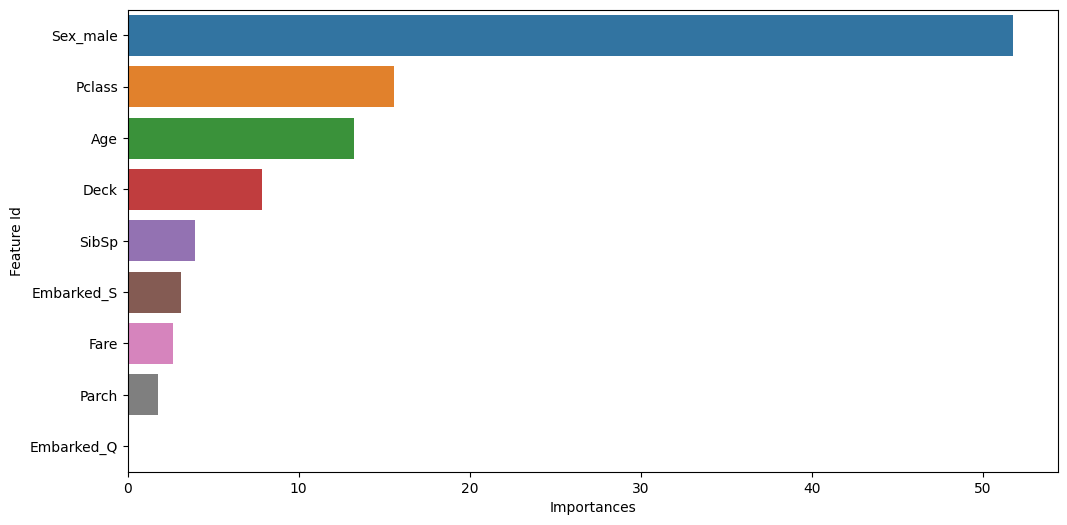

In [46]:
plt.figure(figsize=(12, 6))
sns.barplot(data= cat_model.get_feature_importance(prettified=True),
            x="Importances",
           y='Feature Id')
plt.show()

In [47]:
import shap
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


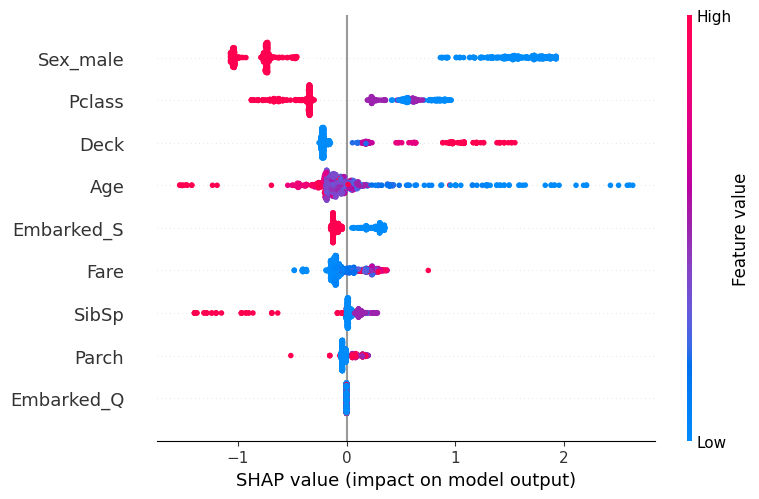

In [48]:
shap.summary_plot(shap_values, X_train)

In [65]:
best_model = CatBoostClassifier(early_stopping_rounds=20,
                                custom_metric='Accuracy',
                                eval_metric='Accuracy',
                                verbose=False,
                                depth=3,
                                random_seed=400,
                                l2_leaf_reg=5,
                                iterations=100,
                                learning_rate=0.2)
best_model.fit(X, y)

In [66]:
predictions = best_model.predict(df_test.drop(['PassengerId'], axis=1))

In [69]:
df_test['Survived'] = predictions

In [73]:
df_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Deck,Sex_male,Embarked_Q,Embarked_S,preds,Survived
0,892,3,34.5,0,0,7.8292,0.299854,1,1,0,0,0
1,893,3,47.0,1,0,7.0000,0.299854,0,0,1,0,0
2,894,2,62.0,0,0,9.6875,0.299854,1,1,0,0,0
3,895,3,27.0,0,0,8.6625,0.299854,1,0,1,0,0
4,896,3,22.0,1,1,12.2875,0.299854,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,21.0,0,0,8.0500,0.299854,1,0,1,0,0
414,1306,1,39.0,0,0,108.9000,0.593220,0,0,0,1,1
415,1307,3,38.5,0,0,7.2500,0.299854,1,0,1,0,0
416,1308,3,21.0,0,0,8.0500,0.299854,1,0,1,0,0


In [76]:
df_test[['PassengerId', 'Survived']].to_csv('Predicts_titanic_1.csv')